In [61]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import glob
import torch.optim as optim
import time

import cv2
%matplotlib inline

In [62]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

In [63]:
data_dir = 'EuroSAT/'
print(os.listdir(data_dir))

['Forest', 'River', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 'Industrial', 'Residential', 'PermanentCrop', 'Pasture']


In [64]:
d = "cpu"
if torch.cuda.is_available():
    d = "cuda:0"
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    d = "mps"
device = torch.device(d)

print("Device: {}".format(device))

Device: mps


In [65]:
class CustomDataset(Dataset):
    def __init__(self,path,image_size):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
        self.class_map = {"AnnualCrop" : 0, "Forest": 1,"HerbaceousVegetation": 2,"Highway": 3,"Industrial":4,"Pasture":5,"PermanentCrop":6,"Residential":7,"River":8,"SeaLake":9}
        self.img_dim = image_size
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        transform = transforms.Compose([transforms.ToTensor()])
        img_tensor = transform(img)
        mean, std, var = torch.mean(img_tensor), torch.std(img_tensor), torch.var(img_tensor)
        img_tensor = (img_tensor-mean)/std
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [66]:
from torch.utils.data.sampler import SubsetRandomSampler

def load_data(path, test_split, val_split, batch_size, input_size, shuffle_dataset=True,random_seed=42):
    dataset = CustomDataset(path,input_size)	
    # Creating data indices for training and test splits:
    dataset_size = len(dataset)
    train_test_indices = list(range(dataset_size))
    test_split = int(np.floor(test_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_test_indices)
    train_indices, test_indices = train_test_indices[test_split:], train_test_indices[:test_split]


   # Creating data indices for training and validation splits:
   
    train_data_size=len(train_indices)
    train_val_indices = list(range(train_data_size))
    val_split = int(np.floor(val_split * train_data_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_val_indices)
    train_indices, val_indices = train_val_indices[val_split:], train_val_indices[:val_split]



    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    data_loader_train = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                              sampler=train_sampler)
    data_loader_test = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=test_sampler)

    data_loader_val = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=val_sampler)


   
    print(len(data_loader_train),len(data_loader_test),len(data_loader_val))
    
    return data_loader_train, data_loader_test, data_loader_val

In [67]:
data_loader_train, data_loader_test, data_loader_val=load_data(data_dir,.2,.2,32,(64,64))


540 169 135


In [68]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


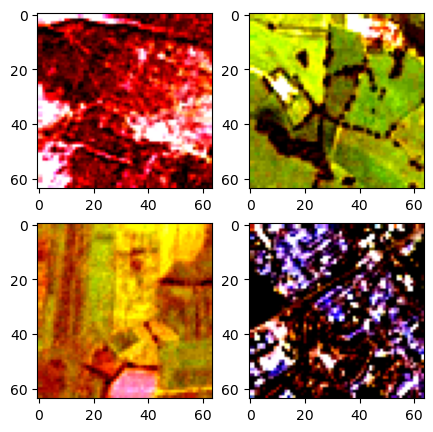

In [69]:
plot_data_loader(data_loader_test,[2,2])

In [70]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
for param in model.parameters():
    param.require_grad = False
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
model.fc = nn.Sequential(
  nn.Flatten(),
  nn.Linear(512, 128),
  nn.ReLU(inplace=True),
  nn.Dropout(.2),
  nn.Linear(128, 10),
  nn.Sigmoid()
)

Using cache found in /Users/madhavtripathi/.cache/torch/hub/pytorch_vision_v0.10.0


In [71]:
optimizer = optim.Adam(model.parameters(),lr=0.001);
criterion = nn.CrossEntropyLoss()


In [72]:
model.to(device)

num_epochs = 20
total_steps = len(data_loader_train)
t1 = time.time()
accuracies = []
losses = []
accuracies_v = []
losses_v = []

for epoch in range(num_epochs):
    ti = 0;
    total_correct = 0;
    tl = 0.0
    for i, data in enumerate(data_loader_train):
        images, labels = data[0].to(device), data[1].to(device)
        labels=torch.flatten(labels)
        outputs = model(images)
        loss = criterion(outputs, labels)
        tl+=loss.item()
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        ti+=total
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        total_correct+= (predicted == labels).sum()

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_steps, 
                          loss.item(),
                      (correct / total) * 100))
    # validation 
    total_correct_v = 0.0
    ti_v = 0
    tl_v = 0.0
    for _, data_v in enumerate(data_loader_val):
        images_v, labels_v = data_v[0].to(device), data_v[1].to(device)
        labels_v=torch.flatten(labels_v)
        outputs_v = model(images_v)
        loss_v = criterion(outputs_v,labels_v)
#         tl_v+=loss_v.item()
        valid_loss = loss_v.item() * images_v.size(0)
        tl_v+=valid_loss
        # Validation accuracy
        total_v = labels_v.size(0)
        ti_v+=total_v
        _,predicted_v = torch.max(outputs_v.data, 1)
        correct_v = (predicted_v == labels_v).sum().item() 
        total_correct_v+= (predicted_v == labels_v).sum() 
    print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, float(tl_v)/ti_v, total_correct_v / ti_v*100.0))
    accuracies_v.append(total_correct_v / ti_v*100.0)    
    losses_v.append(float(tl_v)/ti_v)  
    accuracies.append(total_correct/ti*100.0)
    losses.append(float(tl)/ti)
           
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Epoch [1/20], Step [100/540], Train Loss: 1.8185, Train Accuracy: 40.62%
Epoch [1/20], Step [200/540], Train Loss: 1.8114, Train Accuracy: 53.12%
Epoch [1/20], Step [300/540], Train Loss: 1.7952, Train Accuracy: 56.25%
Epoch [1/20], Step [400/540], Train Loss: 1.8289, Train Accuracy: 43.75%
Epoch [1/20], Step [500/540], Train Loss: 1.7314, Train Accuracy: 43.75%
Epoch [1/20], Validation Loss: 1.7634, Validation Accuracy: 49.00%
Epoch [2/20], Step [100/540], Train Loss: 1.7995, Train Accuracy: 46.88%
Epoch [2/20], Step [200/540], Train Loss: 1.6233, Train Accuracy: 65.62%
Epoch [2/20], Step [300/540], Train Loss: 1.8201, Train Accuracy: 37.50%
Epoch [2/20], Step [400/540], Train Loss: 1.7036, Train Accuracy: 46.88%
Epoch [2/20], Step [500/540], Train Loss: 1.6807, Train Accuracy: 59.38%
Epoch [2/20], Validation Loss: 1.7293, Validation Accuracy: 50.53%
Epoch [3/20], Step [100/540], Train Loss: 1.7937, Train Accuracy: 40.62%
Epoch [3/20], Step [200/540], Train Loss: 1.6723, Train Accurac

Epoch [19/20], Validation Loss: 1.5881, Validation Accuracy: 80.81%
Epoch [20/20], Step [100/540], Train Loss: 1.6783, Train Accuracy: 71.88%
Epoch [20/20], Step [200/540], Train Loss: 1.5099, Train Accuracy: 87.50%
Epoch [20/20], Step [300/540], Train Loss: 1.5516, Train Accuracy: 75.00%
Epoch [20/20], Step [400/540], Train Loss: 1.6056, Train Accuracy: 78.12%
Epoch [20/20], Step [500/540], Train Loss: 1.5830, Train Accuracy: 84.38%
Epoch [20/20], Validation Loss: 1.5892, Validation Accuracy: 81.46%
######## Training Finished in 1212.9112420082092 seconds ###########


In [73]:
torch.save(model, f"eurosat-resnet.pth")

In [74]:
model.eval() 
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in data_loader_test:
        images, labels = data[0].to(device), data[1].to(device)
        labels=torch.flatten(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Test Accuracy of the model on the {} test images: {} %'
  .format(total, (correct / total) * 100))

Test Accuracy of the model on the 5400 test images: 72.01851851851852 %


In [75]:
acc_list = [i.item() for i in accuracies]

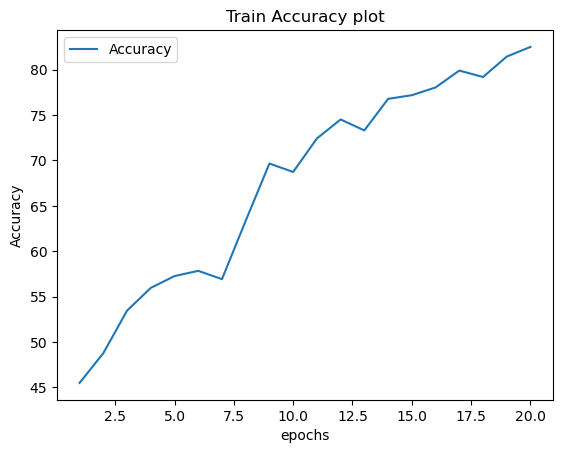

In [76]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy plot')
plt.plot(range(1,num_epochs+1),acc_list)
plt.legend(['Accuracy'])

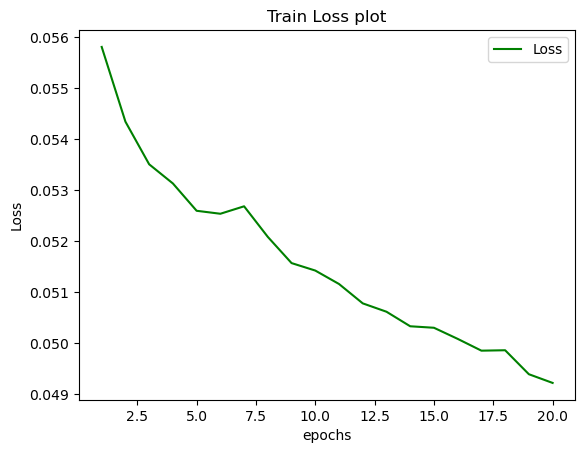

In [77]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Train Loss plot')
plt.plot(range(1,num_epochs+1),losses,'g')
plt.legend(['Loss'])

In [78]:
acc_list_v = [i.item() for i in accuracies_v]

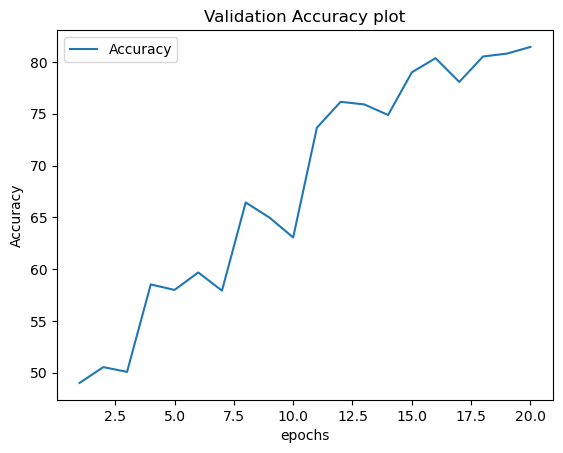

In [79]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy plot')
plt.plot(range(1,num_epochs+1),acc_list_v)
plt.legend(['Accuracy'])

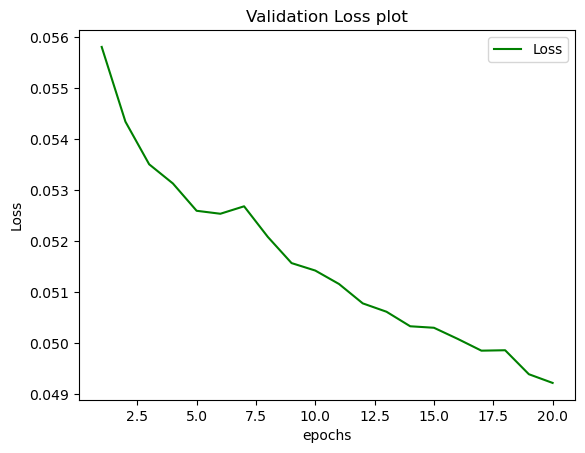

In [80]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Validation Loss plot')
plt.plot(range(1,num_epochs+1),losses,'g')
plt.legend(['Loss'])

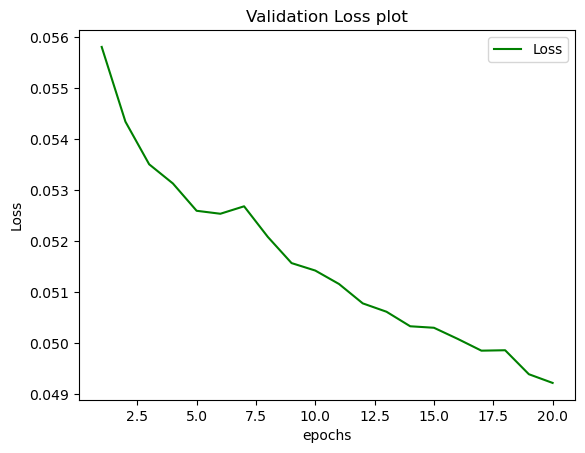

In [81]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Validation Loss plot')
plt.plot(range(1,num_epochs+1),losses,'g')
plt.legend(['Loss'])

[[338   0   0   0   0   0   0   0   0   0]
 [  0 507   0   0   0   0   0   0   0   0]
 [  0   0 169   0 169   0   0   0   0   0]
 [169   0   0 169   0   0   0   0 169   0]
 [  0   0   0   0 169   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 169   0]
 [169   0   0 338   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 676   0   0]
 [  0   0   0 169   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 676]]


<AxesSubplot:>

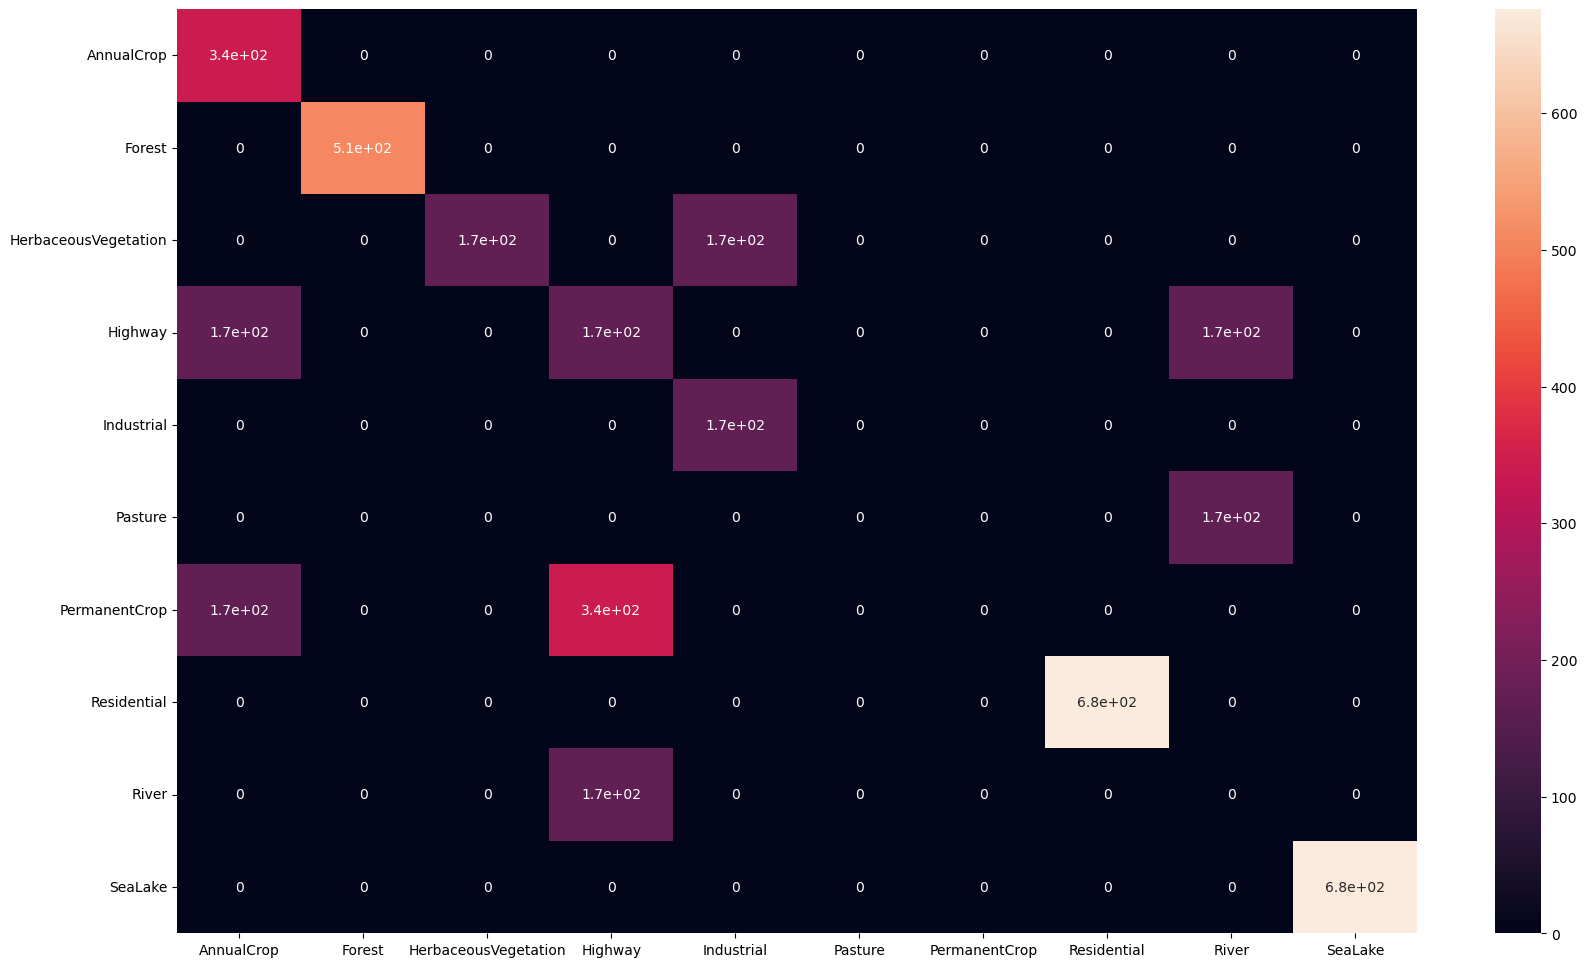

In [82]:
y_pred = []
y_true = []

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

for inputs, labels in data_loader_test:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ("AnnualCrop", "Forest","HerbaceousVegetation","Highway","Industrial","Pasture","PermanentCrop","Residential","River","SeaLake")

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

import seaborn as sns

# sns.heatmap(cf_matrix, annot=True)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20, 12))
sn.heatmap(df_cm, annot=True)


In [83]:

model=torch.load('eurosat-resnet.pth')


In [84]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [85]:
model.to(device)
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in data_loader_test:
        images, labels = data[0].to(device), data[1].to(device)
        labels=torch.flatten(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Test Accuracy of the model on the {} test images: {} %'
  .format(total, (correct / total) * 100))

Test Accuracy of the model on the 5400 test images: 72.01851851851852 %


In [86]:
from ptflops import get_model_complexity_info

# MAC = Multiply–accumulate operation
# MACs = 2 * FLOPs
macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=False,
                                       print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity in FLOPs: ', macs*2))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity in FLOPs:   3643463700.0
Number of parameters:           11243466
